In [ ]:
## 分析每个年级中，那个维度是影响叙事能力的主要维度

In [1]:
## 加载未融合特征的全部特征表
import pandas as pd

full_data = pd.read_csv('./pre_data/全部特征合并表.csv')

full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   文本编号                 300 non-null    object 
 1   单词数量-DESWC-03        300 non-null    int64  
 2   句子数量-DESSC-02        300 non-null    int64  
 3   年级                   300 non-null    int64  
 4   多样性-LDVOCDa（51）      300 non-null    float64
 5   密度-WRDFRQC（94）       300 non-null    float64
 6   复杂度-K1               300 non-null    float64
 7   复杂度-K2               300 non-null    float64
 8   复杂度-K3               300 non-null    float64
 9   复杂度-K4               300 non-null    float64
 10  复杂度-K5               300 non-null    float64
 11  复杂度-K6+              300 non-null    float64
 12  短语长度-SYNLE（69）       300 non-null    float64
 13  短语长度-SYNNP（70）       300 non-null    float64
 14  短语密度-DRNP（76）        300 non-null    float64
 15  短语密度-DRVP（77）        300 non-null    flo

In [7]:
### 加载融合特征的全部特征表
import pandas as pd

full_data_combined = pd.read_csv('./tmp/全部特征合并表_融合.csv')

# 用每一列的均值填充该列的空值(不包括文本编号列)
for col in full_data_combined.columns:
    if col != '文本编号':
        full_data_combined[col].fillna(full_data_combined[col].mean(), inplace=True)

full_data_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   文本编号                    300 non-null    object 
 1   单词数量-DESWC-03           300 non-null    float64
 2   句子数量-DESSC-02           300 non-null    float64
 3   年级                      300 non-null    int64  
 4   多样性-LDVOCDa（51）         300 non-null    float64
 5   密度-WRDFRQC（94）          300 non-null    float64
 6   复杂度-K                   300 non-null    float64
 7   句子长度-DESSL（06）          300 non-null    float64
 8   短语长度-PhraseLength       300 non-null    float64
 9   短语密度-PhraseDensity      300 non-null    float64
 10  句子结构-SentenceStructure  300 non-null    float64
 11  句法相似-SYNSTRUT           300 non-null    float64
 12  局部连贯-LocalCoherence     300 non-null    float64
 13  整体连贯-GlobalCoherence    300 non-null    float64
 14  因果衔接-SMCAUSr-64         300 non-null    fl

/var/folders/c3/wsb8b2lj0_73blm47r0wt1p80000gn/T/ipykernel_50582/2666072929.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_data_combined[col].fillna(full_data_combined[col].mean(), inplace=True)


In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# 1. 数据预处理
def analyze_key_factors():
    # 读取数据
    df = pd.read_csv('pre_data/全部特征合并表.csv')
    
    # 分离特征和目标变量
    feature_cols = [col for col in df.columns if col not in ['文本编号', '年级']]
    X = df[feature_cols]
    y = df['年级']  # 使用年级作为叙事能力的代理变量
    
    # 标准化特征
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 2. 特征重要性分析
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)
    
    # 获取特征重要性
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # 3. 相关性分析
    correlations = []
    for feature in feature_cols:
        corr, p_value = pearsonr(df[feature], df['年级'])
        correlations.append({
            'feature': feature,
            'correlation': corr,
            'p_value': p_value
        })
    
    corr_df = pd.DataFrame(correlations)
    
    # 4. 综合评分
    # 结合特征重要性和相关性
    merged_df = feature_importance.merge(corr_df, on='feature')
    merged_df['composite_score'] = (
        merged_df['importance'] * 0.6 + 
        abs(merged_df['correlation']) * 0.4
    )
    merged_df = merged_df.sort_values('composite_score', ascending=False)
    
    return merged_df, feature_importance, corr_df

# 5. 可视化结果
def visualize_results(merged_df, feature_importance):
    plt.rcParams['font.sans-serif'] = ['PingFang HK']
    plt.rcParams['axes.unicode_minus'] = False       
    plt.rcParams['font.family'] = 'PingFang HK'
    # 绘制特征重要性图
    plt.figure(figsize=(12, 8))
    
    # 前15个最重要的特征
    top_features = merged_df.head(15)
    
    plt.subplot(2, 1, 1)
    plt.barh(range(len(top_features)), top_features['composite_score'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('综合评分')
    plt.title('叙事能力关键要素排序')
    
    # 相关性热力图
    plt.subplot(2, 1, 2)
    correlation_matrix = top_features[['importance', 'correlation', 'composite_score']]
    sns.heatmap(correlation_matrix.T, annot=True, cmap='coolwarm', center=0)
    plt.title('关键要素评分相关性')
    
    plt.tight_layout()
    plt.show()
    
    return top_features

# 6. 按维度分组分析
def analyze_by_dimension(merged_df):
    # 定义维度映射
    dimension_mapping = {
        '词法': ['多样性', '密度', '复杂度'],
        '句法': ['短语长度', '短语密度', '句子长度', '句子结构', '句法相似'],
        '语篇连贯': ['局部连贯', '整体连贯'],
        '情境模型': ['因果衔接', '意图衔接', '时体衔接'],
        '段落结构': ['段落平均长度']
    }
    
    dimension_results = {}
    for dimension, keywords in dimension_mapping.items():
        relevant_features = []
        for feature in merged_df['feature']:
            if any(keyword in feature for keyword in keywords):
                relevant_features.append(feature)
        
        if relevant_features:
            dimension_df = merged_df[merged_df['feature'].isin(relevant_features)]
            dimension_results[dimension] = {
                'features': dimension_df,
                'avg_importance': dimension_df['importance'].mean(),
                'avg_correlation': abs(dimension_df['correlation']).mean(),
                'avg_composite': dimension_df['composite_score'].mean()
            }
    
    return dimension_results

In [9]:
merged_df, feature_importance, corr_df = analyze_key_factors()

/opt/anaconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 26434 (\N{CJK UNIFIED IDEOGRAPH-6742}) missing from font(s) PingFang HK.
  fig.canvas.draw()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26434 (\N{CJK UNIFIED IDEOGRAPH-6742}) missing from font(s) PingFang HK.
  fig.canvas.print_figure(bytes_io, **kw)


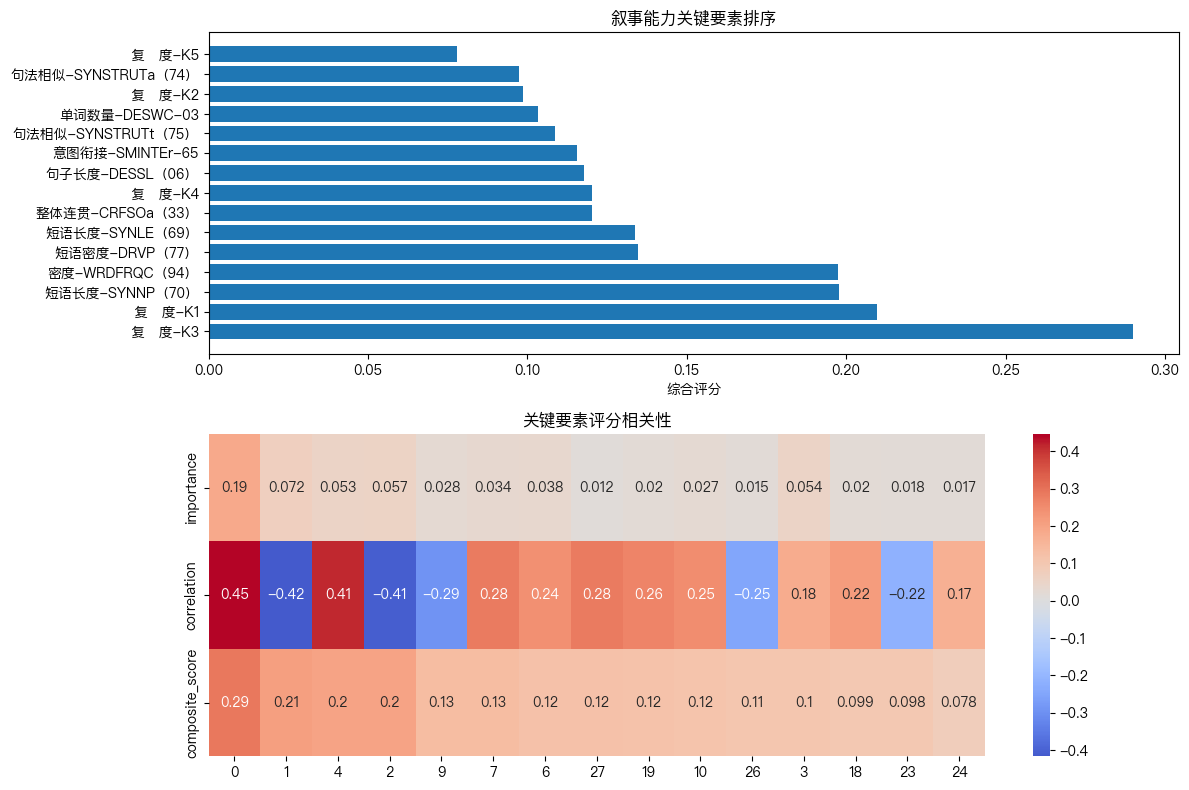

,feature,importance,correlation,p_value,composite_score
0,复杂度-K3,0.185641,0.446325,4.303062e-16,0.289915
1,复杂度-K1,0.072027,-0.416343,5.247522e-14,0.209753
4,短语长度-SYNNP（70）,0.053007,0.414941,6.493961e-14,0.197781
2,密度-WRDFRQC（94）,0.057059,-0.407879,1.872095e-13,0.197387
9,短语密度-DRVP（77）,0.028252,-0.294003,2.147667e-07,0.134552
7,短语长度-SYNLE（69）,0.033688,0.283655,5.867577e-07,0.133675
6,整体连贯-CRFSOa（33）,0.038480,0.243165,2.060441e-05,0.120354
27,复杂度-K4,0.012352,0.281865,6.953937e-07,0.120157
19,句子长度-DESSL（06）,0.019918,0.264471,3.407058e-06,0.117739
10,意图衔接-SMINTEr-65,0.026550,0.249414,1.235513e-05,0.115696


In [12]:
visualize_results(merged_df,feature_importance)

In [14]:
analyze_by_dimension(merged_df)

{'词法': {'features':             feature  importance  correlation       p_value  composite_score
  0            复杂度-K3    0.185641     0.446325  4.303062e-16         0.289915
  1            复杂度-K1    0.072027    -0.416343  5.247522e-14         0.209753
  2    密度-WRDFRQC（94）    0.057059    -0.407879  1.872095e-13         0.197387
  9     短语密度-DRVP（77）    0.028252    -0.294003  2.147667e-07         0.134552
  27           复杂度-K4    0.012352     0.281865  6.953937e-07         0.120157
  18           复杂度-K2    0.020120     0.216236  1.603670e-04         0.098567
  24           复杂度-K5    0.017305     0.168478  3.423599e-03         0.077774
  14    短语密度-DRPP（79）    0.021173     0.080838  1.625327e-01         0.045039
  8     短语密度-DRNP（76）    0.032327     0.040885  4.805092e-01         0.035750
  13  多样性-LDVOCDa（51）    0.021359     0.047060  4.167068e-01         0.031639
  22          复杂度-K6+    0.017971     0.041636  4.724701e-01         0.027437,
  'avg_importance': 0.04414433939185471,
  'a